## importing libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import random
import os

### checking for gpu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# =========================
# 2. Helper function: Balanced subset
# =========================
def get_balanced_subset(dataset, per_class_count):
    """Return indices for a balanced subset from ImageFolder dataset."""
    targets = dataset.targets  # list of class indices
    indices_per_class = {cls: [] for cls in set(targets)}

    for idx, label in enumerate(targets):
        indices_per_class[label].append(idx)

    final_indices = []
    for cls, idxs in indices_per_class.items():
        sampled = random.sample(idxs, per_class_count)
        final_indices.extend(sampled)

    random.shuffle(final_indices)
    return final_indices


In [5]:
# =========================
# 3. Data Loading
# =========================
data_dir = "data/real_vs_fake/real_vs_fake"  # Change path if needed

train_tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_test_tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load datasets
train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_tf)
val_ds = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=val_test_tf)
test_ds = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_tf)

# Create balanced subsets
train_indices = get_balanced_subset(train_ds, 10000)  # 10k per class
val_indices = get_balanced_subset(val_ds, 2000)       # 2k per class
test_indices = get_balanced_subset(test_ds, 2000)     # 2k per class

train_ds = Subset(train_ds, train_indices)
val_ds = Subset(val_ds, val_indices)
test_ds = Subset(test_ds, test_indices)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=2)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")


Train size: 20000 | Val size: 4000 | Test size: 4000


In [6]:
# =========================
# 4. Model (ResNet18)
# =========================
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Pretrained
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: real, fake
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.7MB/s]


In [9]:
# =========================
# 5. Training Loop
# =========================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10 Train Loss: 0.1795 Train Acc: 0.9274 Val Loss: 0.2060 Val Acc: 0.9157
Epoch 2/10 Train Loss: 0.1407 Train Acc: 0.9456 Val Loss: 0.1515 Val Acc: 0.9387
Epoch 3/10 Train Loss: 0.1158 Train Acc: 0.9547 Val Loss: 0.1502 Val Acc: 0.9435
Epoch 4/10 Train Loss: 0.0979 Train Acc: 0.9639 Val Loss: 0.1537 Val Acc: 0.9427
Epoch 5/10 Train Loss: 0.0802 Train Acc: 0.9712 Val Loss: 0.1598 Val Acc: 0.9475
Epoch 6/10 Train Loss: 0.0767 Train Acc: 0.9721 Val Loss: 0.1464 Val Acc: 0.9493
Epoch 7/10 Train Loss: 0.0636 Train Acc: 0.9769 Val Loss: 0.1829 Val Acc: 0.9365
Epoch 8/10 Train Loss: 0.0563 Train Acc: 0.9782 Val Loss: 0.1518 Val Acc: 0.9547
Epoch 9/10 Train Loss: 0.0522 Train Acc: 0.9810 Val Loss: 0.1286 Val Acc: 0.9533
Epoch 10/10 Train Loss: 0.0511 Train Acc: 0.9829 Val Loss: 0.1259 Val Acc: 0.9547


In [11]:
model.eval()
test_loss = 0.0
test_correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        total += labels.size(0)

test_loss /= total
test_acc = test_correct.double() / total
print(f"Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")


Test Loss: 0.1333  Test Acc: 0.9527


In [12]:
torch.save(model.state_dict(), "fake_vs_real_cnn.pth")


In [13]:
model.load_state_dict(torch.load("fake_vs_real_cnn.pth"))
model.eval()


C:\Users\user\AppData\Local\Temp\ipykernel_1924\1594003501.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fake_vs_real_cnn.pth"))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets
import torch

# Match preprocessing from training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load dataset to get class mapping
data_dir = "data/real_vs_fake/real_vs_fake"  # adjust path if needed
train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
class_names = train_dataset.classes  # e.g., ['fake', 'real']

# Load and preprocess image
img = Image.open("D:/projects/fake_face_detection/data/real_vs_fake/real_vs_fake/test/fake/0CVV5R10MS.jpg").convert('RGB')
img = transform(img).unsqueeze(0).to(device)

# Inference
model.eval()
with torch.no_grad():
    output = model(img)
    _, pred = torch.max(output, 1)

# Map prediction to class name
predicted_class = class_names[pred.item()]
print(f"Face is {predicted_class}")


Face is fake


C:\Users\user\AppData\Local\Temp\ipykernel_1924\2672322659.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fake_vs_real_cnn.pth", map_l

Test Accuracy: 0.9527

Confusion Matrix:
 [[1885  115]
 [  74 1926]]

Classification Report:
               precision    recall  f1-score   support

        Fake       0.96      0.94      0.95      2000
        Real       0.94      0.96      0.95      2000

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



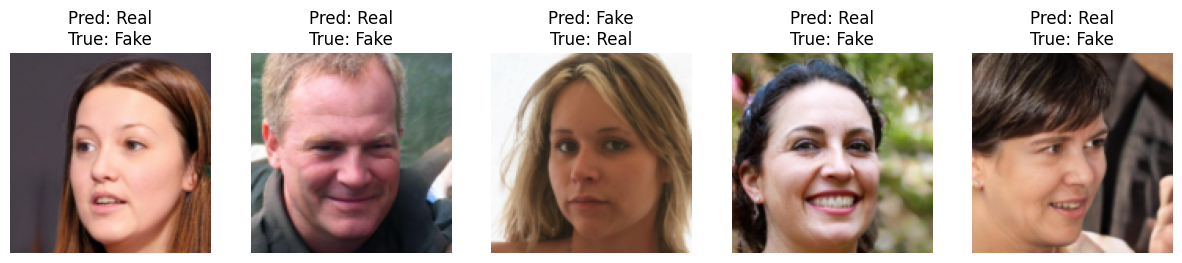

In [33]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# ==== 1. Load model ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("fake_vs_real_cnn.pth", map_location=device))
model.to(device)
model.eval()

# ==== 2. Run on test set ====
y_true = []
y_pred = []
misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        
        # Save some misclassified examples
        for img, pred, label in zip(images, preds, labels):
            if pred != label and len(misclassified_images) < 5:
                misclassified_images.append(img.cpu())
                misclassified_preds.append(pred.item())
                misclassified_labels.append(label.item())

# ==== 3. Metrics ====
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

# ==== 4. Show 5 misclassified examples ====
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Pred: {'Real' if misclassified_preds[i] else 'Fake'}\nTrue: {'Real' if misclassified_labels[i] else 'Fake'}")
    ax.axis("off")
plt.show()


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


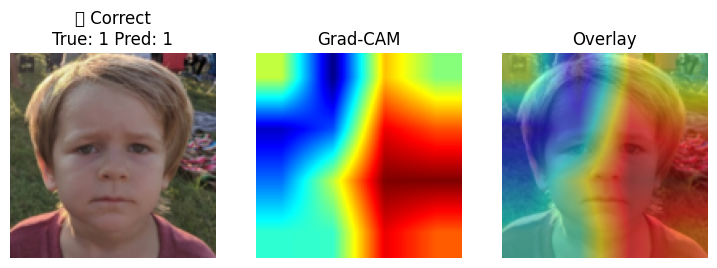

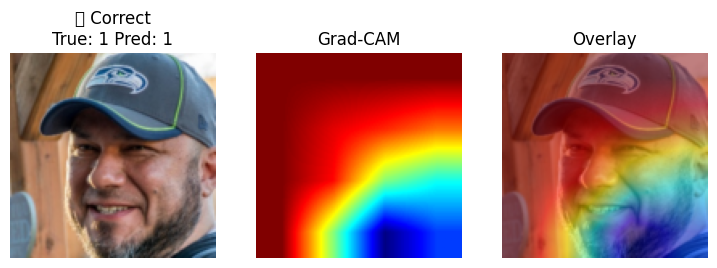

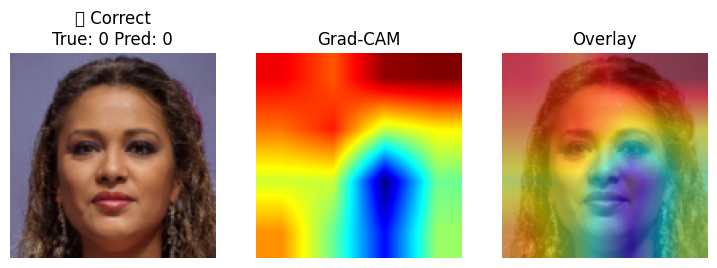

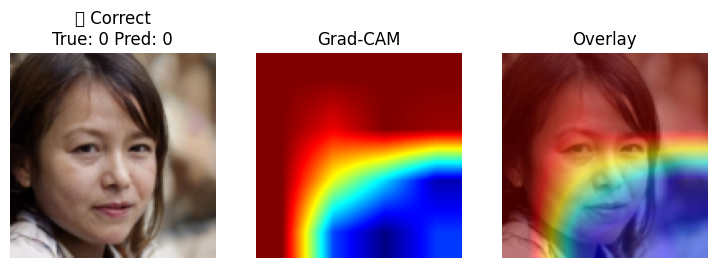

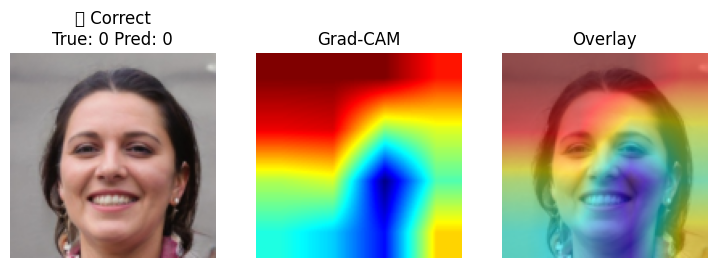

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


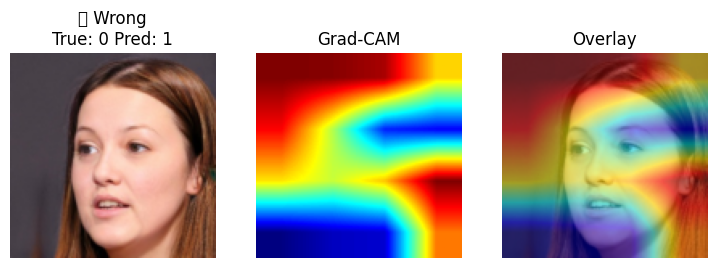

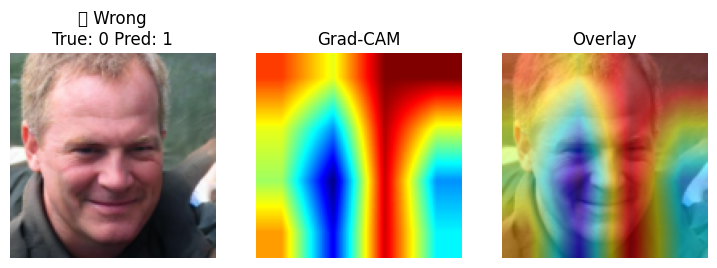

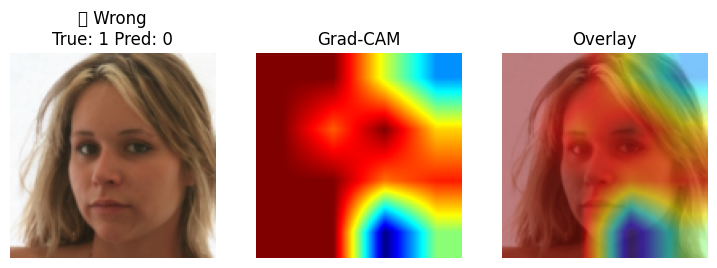

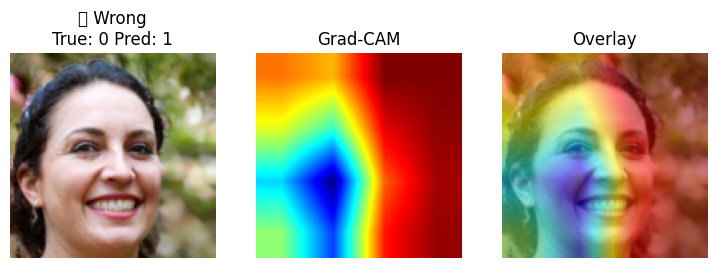

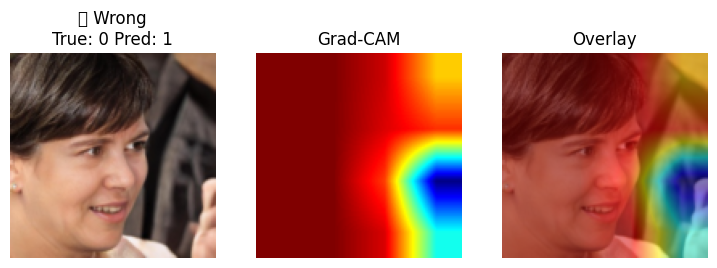

In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ===========
# Grad-CAM Hook Functions
# ===========
gradients = []
activations = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Hook into the last conv layer of ResNet
target_layer = model.layer4[-1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# ===========
# Grad-CAM Function
# ===========
def generate_gradcam(input_tensor, target_class=None):
    global gradients, activations
    gradients, activations = [], []

    # Forward pass
    output = model(input_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Backward pass for the target class
    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()

    # Get activations and gradients
    acts = activations[0].detach().cpu().numpy()[0]
    grads = gradients[0].detach().cpu().numpy()
    weights = np.mean(grads, axis=(1, 2))

    # Compute CAM
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam

# ===========
# Visualization Function
# ===========
def show_gradcam_on_image(img_tensor, cam):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    overlay = heatmap + img
    overlay = overlay / np.max(overlay)

    return img, heatmap, overlay

# ===========
# Run on Test Set
# ===========
model.eval()
right_count = 0
wrong_count = 0
max_examples = 5  # how many of each to show

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    for i in range(len(images)):
        cam = generate_gradcam(images[i].unsqueeze(0), target_class=preds[i].item())
        img, heatmap, overlay = show_gradcam_on_image(images[i], cam)

        if preds[i] == labels[i] and right_count < max_examples:
            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f"✅ Correct\nTrue: {labels[i].item()} Pred: {preds[i].item()}")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(heatmap)
            plt.title("Grad-CAM")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(overlay)
            plt.title("Overlay")
            plt.axis("off")

            plt.show()
            right_count += 1

        elif preds[i] != labels[i] and wrong_count < max_examples:
            plt.figure(figsize=(9, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f"❌ Wrong\nTrue: {labels[i].item()} Pred: {preds[i].item()}")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(heatmap)
            plt.title("Grad-CAM")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(overlay)
            plt.title("Overlay")
            plt.axis("off")

            plt.show()
            wrong_count += 1

    if right_count >= max_examples and wrong_count >= max_examples:
        break
